In [1]:
project_dir = os.path.split(os.getcwd())[0]
if project_dir not in sys.path:
    sys.path.append(project_dir)

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn.functional import one_hot

import torchvision
from torchvision.transforms import Compose, ToTensor, ToPILImage, Normalize

import numpy as np
from matplotlib import pyplot as plt
import random


from InformationPlane import TensorKernel, MatrixBasedRenyisEntropy, RKHSMatrixOptimizer, InformationPlane
from models.Paper import CNN

### Load MNIST dataset

In [3]:
transformToTensor = Compose([ ToTensor(), Normalize((0.1307,), (0.3081,))])
# transformToTensor = Compose([ ToTensor()])

transformToImage = Compose([  Normalize((-0.1307/0.3081,), (1/0.3081,)), ToPILImage()])
# transformToImage = Compose([ ToPILImage()])

dataset = torchvision.datasets.MNIST("../datasets/MNIST/", train=True, download=True, transform=transformToTensor)

dataloader = DataLoader(dataset, batch_size=100, shuffle=True, num_workers=0)

### Preparing test


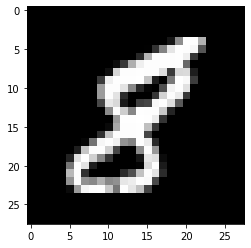

In [4]:
for input, label in dataloader:
    plt.imshow(transformToImage(input[0]), cmap="gray")
    plt.show()
    label = one_hot(label).float()
    # print(label)
    break

model = CNN()
layer = model.conv_layers[0]

input_kernel_matrix = MatrixBasedRenyisEntropy.tensorRBFMatrix(input.flatten(1), 8)

label_kernel_matrix = MatrixBasedRenyisEntropy.tensorRBFMatrix(label, 0.1)

### Information plane test

In [5]:
class RKHSMatrixOptimizer():
    def __init__(self, beta=0.5):
        if not(0 <= beta <= 1):
            raise Exception('beta must be in the range [0, 1]')

        self.beta = beta
        self.sigma = None
        self.sigma_tmp = [] #Just for saving sigma values

    # Temporal, just for testing
    def getSigmaValues(self):
        return self.sigma_tmp

    def getSigma(self):
        return self.sigma

    '''
        @param The output of a specific layer
        @param label_kernel_matrix
        @param n_sigmas
    '''
    def step(self, layer_output, Ky, n_sigmas=75):
        sigma_t = self.optimize(layer_output, Ky, n_sigmas)
        self.sigma = ( (self.beta*self.sigma) + ((1-self.beta)*sigma_t) ) if not(self.sigma is None) else sigma_t
        return self.getSigma()

    '''
        This function is used in orter to obtain the optimal kernel width for
        an T DNN layer

        @param layer_output
        @param n_sigmas: number of possible sigma values

        [Descripción del procedimiento]
    '''
    def optimize(self, layer_output, Ky, n_sigmas):
        distance = torch.cdist(layer_output, layer_output)
        mean_distance = distance[distance != 0].mean().detach().cpu()
        sigma_values = np.arange(mean_distance*0.1, mean_distance*10, (mean_distance*10 - mean_distance*0.1)/n_sigmas)

        Kt = list( map(lambda sigma: TensorKernel.RBF(layer_output, sigma).detach(), sigma_values.tolist()) )
        loss = np.array( list( map(lambda k: self.kernelAligmentLoss(k, Ky), Kt) ) )
        self.sigma_tmp.append(sigma_values[ np.argwhere(loss == loss.max()).item(0) ])
        return sigma_values[ np.argwhere(loss == loss.max()).item(0) ]

    '''
        Kernel Aligment Loss Function.

        This function is used in order to obtain the optimal sigma parameter from
        RBF kernel.  
    '''
    def kernelAligmentLoss(self, x, y):
        return (torch.sum(x*y))/(torch.norm(x) * torch.norm(y))



class InformationPlane(torch.nn.Module):
    '''
        @param input_kernel: preprocessed input kernel matrix
        @param input_kernel: preprocessed label kernel matrix
        @param sigma_values: number of possible sigma values for optimizing process.
        @param step: indicates the number of step for reducing the number of possible sigma values
    '''
    def __init__(self, mini_batch_size, beta=0.5):
        super(InformationPlane, self).__init__()

        self.mini_batch_size = mini_batch_size
        self.sigma_optimizer = RKHSMatrixOptimizer(beta)
        self.Ixt = []
        self.Ity = []

    '''
        @param beta regularizer term to stabilize the optimal sigma value across the previous iteration
        
        @return mutual information with label {I(X,T), I(T,Y)}
    '''
    def forward(self, x, input, label, beta=0.5):
        original_shape = x.shape
        x = x.flatten(1)

        Ixt = [] # Mutual Information with input I(X, T)
        Ity = [] # Mutual Information with label I(T, Y)

        # Dividir en minibatchs [x]
        # Utilizar el optimizador [x]
        # Obtener la matrix A con el valor de sigma optimizado [x]

        for idx in range(0, len(x), self.mini_batch_size):
            batch = x[idx:idx+self.mini_batch_size]
            input_batch = input[idx:idx+self.mini_batch_size].flatten(1)
            label_batch = label[idx:idx+self.mini_batch_size]
            label_kernel_matrix = TensorKernel.RBF(label_batch, 0.1)
            
            self.sigma_optimizer.step(batch, label_kernel_matrix, 75)            

            A = MatrixBasedRenyisEntropy.tensorRBFMatrix(batch, self.sigma_optimizer.getSigma()).detach()
            Ay = MatrixBasedRenyisEntropy.tensorRBFMatrix(label_batch, 0.5).detach()
            Ax = MatrixBasedRenyisEntropy.tensorRBFMatrix(input_batch, 4).detach()
            Ixt.append(MatrixBasedRenyisEntropy.mutualInformation(Ax, A))
            Ity.append(MatrixBasedRenyisEntropy.mutualInformation(A, Ay))

        self.Ixt.append(np.array(Ixt).mean())
        self.Ity.append(np.array(Ity).mean())

        x = x.reshape(original_shape)
        return x

    ''' 
        @return Mutual Information {I(X,T), I(T,Y)}
    '''
    def getMutualInformation(self):
        return self.Ixt, self.Ity


In [51]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 4, 3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4)
        )

        self.layer1_IP = InformationPlane(100)

        self.layer2 = nn.Sequential(
            nn.Conv2d(4, 8, 3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, stride=2, ceil_mode=True)
        )

        self.layer2_IP = InformationPlane(100)

        self.layer3 = nn.Sequential(
            nn.Conv2d(8, 16, 3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, stride=2, ceil_mode=True)
        )

        self.layer3_IP = InformationPlane(100)

        self.fc = nn.Sequential(
            nn.Linear(400, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Linear(256, 10),
        )

        self.fc_IP = InformationPlane(100)
        self.softmax = torch.nn.Softmax()

    def forward(self, x, input, label):
        x = self.layer1[0](x)
        x = self.layer1_IP(x, input, label)
        x = self.layer1[1:](x)
        x = self.layer2[0](x)
        x = self.layer2_IP(x, input, label)
        x = self.layer2[1:](x)
        x = self.layer3[0](x)
        x = self.layer3_IP(x, input, label)
        x = self.layer3[1:](x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        self.fc_IP(x, input, label)
        return x

# Multilayer Perceptron

In [62]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1024)
        )

        self.layer1_IP = InformationPlane(100)

        self.layer2 = nn.Sequential(
            nn.Linear(1024, 20),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(20)
        )

        self.layer2_IP = InformationPlane(100)

        self.layer3 = nn.Sequential(
            nn.Linear(20, 20),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(20)
        )

        self.layer3_IP = InformationPlane(100)

        self.layer4 = nn.Sequential(
            nn.Linear(20, 20),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(20)
        )

        self.layer4_IP = InformationPlane(100)

        self.layer5 = nn.Sequential(
            nn.Linear(20, 10)
        )

        self.layer5_IP = InformationPlane(100)

        self.softmax = torch.nn.Softmax()

    def forward(self, x, input, label):
        x = self.layer1[0](x)
        x = self.layer1_IP(x, input, label)
        x = self.layer1[1:](x)
        x = self.layer2[0](x)
        x = self.layer2_IP(x, input, label)
        x = self.layer2[1:](x)
        x = self.layer3[0](x)
        x = self.layer3_IP(x, input, label)
        x = self.layer3[1:](x)
        x = self.layer4[0](x)
        x = self.layer4_IP(x, input, label)
        x = self.layer4[1:](x)
        x = self.layer5[0](x)
        self.layer5_IP(x, input, label)
        return x

In [52]:
# net = CNN().cuda()
net = MPL().cuda
# test = net(input.cuda(), input, label)

# Training

In [53]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, (inputs, labels) in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs, inputs, one_hot(labels).float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 25 == 0:    # print every 250 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 25))
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.096
[1,    26] loss: 0.783
[1,    51] loss: 0.233
[1,    76] loss: 0.156
[1,   101] loss: 0.125
[1,   126] loss: 0.102
[1,   151] loss: 0.105
[1,   176] loss: 0.073
[1,   201] loss: 0.082
[1,   226] loss: 0.069
[1,   251] loss: 0.065
[1,   276] loss: 0.077
[1,   301] loss: 0.074
[1,   326] loss: 0.057
[1,   351] loss: 0.064
[1,   376] loss: 0.075
[1,   401] loss: 0.052
[1,   426] loss: 0.056
[1,   451] loss: 0.063
[1,   476] loss: 0.059
[1,   501] loss: 0.070
[1,   526] loss: 0.065
[1,   551] loss: 0.048
[1,   576] loss: 0.048
Finished Training


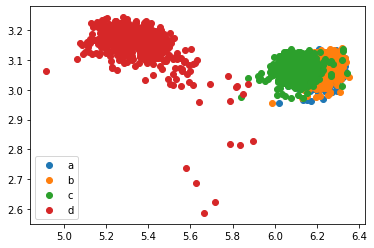

In [55]:
plt.scatter(net.layer1_IP.getMutualInformation()[0], net.layer1_IP.getMutualInformation()[1], label="a")
plt.scatter(net.layer2_IP.getMutualInformation()[0], net.layer2_IP.getMutualInformation()[1], label="b")
plt.scatter(net.layer3_IP.getMutualInformation()[0], net.layer3_IP.getMutualInformation()[1], label="c")
plt.scatter(net.fc_IP.getMutualInformation()[0], net.fc_IP.getMutualInformation()[1], label="d")
plt.legend()

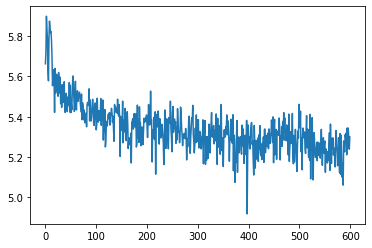

In [56]:
plt.plot(net.fc_IP.getMutualInformation()[0])

In [57]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

Ixt = np.array(net.layer1_IP.getMutualInformation()[0])
Ity = np.array(net.layer1_IP.getMutualInformation()[1])

Ixt_average = moving_average(Ixt, 10)
Ity_average = moving_average(Ity, 10)

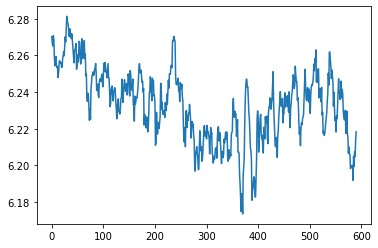

In [58]:
plt.plot(Ixt_average)
plt.show()

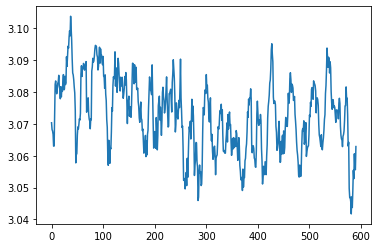

In [59]:
plt.plot(Ity_average)
plt.show()

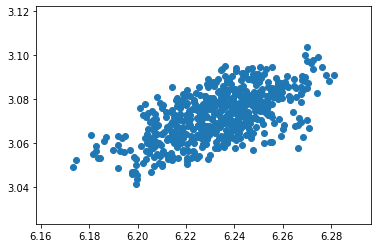

In [60]:
plt.scatter(Ixt_average, Ity_average)
plt.show()

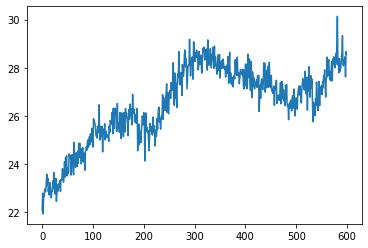

In [61]:
plt.plot(net.layer1_IP.sigma_optimizer.getSigmaValues())
plt.show()

In [1]:
plt.plot(moving_average(net.layer1_IP.sigma_optimizer.getSigmaValues(), 10))

NameError: name 'plt' is not defined